# Group project - DATA201

> By Oscar Toohey, Jamie Barnes, Seth Gunn, Bach Vu, Angus Loader


# How COVID affect living price in New Zealand

## Data Source (dir `data/`):
| Location | Content | URL |
|----|----|----|
| `household.csv` | CPI |  |
| `Overseas.csv`| Import/Export by tonnes |  |
| `Number_of_covid.csv` | Covid statistic by Health Ministry |  |

### R libraries

In [1]:
library(tidyverse)
library(rvest)
library(magrittr) # better handling of pipes

library(purrr) # to work with lists and map functions
library(glue)
library(stringr) # to handle string conversion

# install.packages("zoo") # as.yearqtr
# install.packages("skim")
library(zoo)
# library(skim)

library(ggplot2)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.3     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'rvest' was built under R version 4.1.1"

Attaching package: 'rvest'


The following object is masked from 'package:readr':

    guess_encoding



Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'glue'


The following object is masked from 'package:dplyr':

    collapse


Warning message:
"package 'zoo' was built under R version 4.1.1"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.nume

### Covid stats


Import data

In [2]:
covid_case_df <- read_csv("data/Number_of_cases.csv")
hpi_df <- read_csv("data/household-living-costs-price-indexes-June-2021-quarter-time-series-indexes.csv")

covid_case_df %>% glimpse()
hpi_df %>% glimpse()

New names:
* `` -> ...1

Rows: 1554 Columns: 18

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (13): ResourceID, Subject, Title, Description, Source, SourceURL, Frequ...
dbl   (3): ...1, Value, Multiplier
dttm  (1): Modified
date  (1): Period


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 45262 Columns: 11

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): hlpi_name, series_ref, quarter, hlpi, nzhec, nzhec_name, nzhec_shor...
dbl (3): index, change.q, change.a


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Rows: 1,554
Columns: 18
$ ...1        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,~
$ ResourceID  <chr> "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2"~
$ Subject     <chr> "COVID-19", "COVID-19", "COVID-19", "COVID-19", "COVID-19"~
$ Title       <chr> "Number of Cases", "Number of Cases", "Number of Cases", "~
$ Description <chr> "COVID-19 cases in New Zealand (cumulative)", "COVID-19 ca~
$ Source      <chr> "Ministry of Health", "Ministry of Health", "Ministry of H~
$ SourceURL   <chr> "https://www.health.govt.nz/our-work/diseases-and-conditio~
$ Modified    <dttm> 2021-10-06 11:00:00, 2021-10-06 11:00:00, 2021-10-06 11:0~
$ Frequency   <chr> "Daily", "Daily", "Daily", "Daily", "Daily", "Daily", "Dai~
$ Var1        <chr> "Case status", "Case status", "Case status", "Case status"~
$ id          <chr> "3934f4da-e3ed-43c4-8656-441f49f9c7ca", "2a4fa96a-27a1-423~
$ Period      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-0~
$ Duration    <c

Create helpers

In [3]:
convertToWeek <- function(date, format="%V-%Y") {
    return (strftime(date, format=format))
}

getFirstDayOfWeek <- function(date) {
    weekIndex = strtoi(convertToWeek(date, format="%V"), base=10L)
    year = convertToWeek(date, format="%Y")
    string <- paste(year, weekIndex, "1", sep="-") # 1 for Monday
    return (string)
}

getByStatus <- function(data, status, rename=FALSE) {
    result <- data %>% filter(Status==status)
    if (rename == TRUE) {
        result %<>% select(Value, Date) 
        names(result)[names(result) == 'Value'] <- status
    }
    return (result)
}

trim_Covid_Raw_df <-function(covid_df, option) {
    covid_df <- covid_df %>% rename(Status=Label1, Date=Period)
    covid_df %<>% mutate(
        Week = map_chr(Date, convertToWeek),
        Monday = map_chr(Date, getFirstDayOfWeek)
    )
    suppressWarnings( # There is not good record in raw data, see Failure in report
        covid_df <- transform(covid_df, Monday=as.Date(Monday, format="%Y-%U-%u"))
    )
    
    if (option == "Status") {
        covid_status_df <- covid_df %>% select(Value, Date, Status) %>%
                                        group_by(Status) %>% summarise()
        return (covid_status_df)        
    }
    
    deceased_covid_case_df <- getByStatus(covid_df, "Deceased", TRUE)
    recovered_covid_case_df <- getByStatus(covid_df, "Recovered", TRUE)
    active_covid_case_df <- getByStatus(covid_df, "Active", TRUE)
    if (option == "Deceased") {
        return (deceased_covid_case_df)
    } else if (option == "Recovered") {
        return (recovered_covid_case_df)
    } else if (option == "Active") {
        return (active_covid_case_df)
    }    
    
    temp <- merge(x = deceased_covid_case_df, y = recovered_covid_case_df, 
                  by = "Date", all = TRUE)
    covid_case_mutated_df <- merge(x = temp, y = active_covid_case_df, 
                                   by = "Date", all = TRUE) # Outer join
    if (option == "Sample") {        
        newdata <- covid_case_mutated_df %>% sample_n(10)
        return (newdata[order(newdata$Date),])
    } else if (option == "Summary") {
        return (covid_case_mutated_df) # Trim unecessary cols
    }
    
    return (covid_df)
}

savePlot <- function(filename, df_plot) {
    ggsave(paste("img", filename, sep="/"), plot = df_plot)
}

Explore data

In [4]:
# Test
trim_Covid_Raw_df(covid_case_df, "Status")
trim_Covid_Raw_df(covid_case_df, "Deceased") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Recovered") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Active") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Sample")
trim_Covid_Raw_df(covid_case_df, "Summary") %>% glimpse()

Status
<chr>
Active
Deceased
Recovered


Rows: 518
Columns: 2
$ Deceased <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ Date     <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-05, ~
Rows: 518
Columns: 2
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Date      <date> 2020-02-28, 2020-03-01, 2020-02-29, 2020-03-03, 2020-03-02,~
Rows: 518
Columns: 2
$ Active <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 6, 5, 8, 8, 12, 20, 2~
$ Date   <date> 2020-02-28, 2020-03-01, 2020-03-02, 2020-03-03, 2020-02-29, 20~


,Date,Deceased,Recovered,Active
,<date>,<dbl>,<dbl>,<dbl>
9,2020-03-10,0,0,5
4,2020-04-22,14,1036,401
8,2020-06-08,22,1482,0
7,2020-07-12,22,1497,25
6,2020-08-20,22,1531,101
5,2020-10-10,25,1801,44
10,2021-01-20,25,2166,76
3,2021-02-19,26,2272,50
1,2021-05-18,26,2608,19


Rows: 518
Columns: 4
$ Date      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-03,~
$ Deceased  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Active    <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 12, 20~


Wrangle data and graphing

In [5]:
# Source: http://rstudio-pubs-static.s3.amazonaws.com/3256_bb10db1440724dac8fa40da5e658ada5.html
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1))
graph_df <- trim_Covid_Raw_df(covid_case_df, "")
graph_week_df <- graph_df %>%
    group_by(Monday, Status, Week) %>%
    summarise(Value = mean(Value))

options(repr.plot.width = 14, repr.plot.height = 10) # Size of graph display

`summarise()` has grouped output by 'Monday', 'Status'. You can override using the `.groups` argument.



In [6]:
new_case_plot <- ggplot(data = getByStatus(graph_df, "Active"), 
               aes(x=Date, y=Value)
        ) +
        geom_line(colour=color[1], size=2) +
#         geom_line(data = getByStatus(graph_df, "Recovered"), colour=color[2], size=2) +
#         geom_line(data = getByStatus(graph_df, "Deceased"), colour=color[3], size=2) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

new_case_plot <- new_case_plot +
ggtitle("New case by Week") +
ylab("Total cases") + xlab("Month")

In [7]:
graph_week_df$Status <- factor(graph_week_df$Status, 
                               levels = c("Active", "Recovered", "Deceased"))

covid_weekly_plot <- ggplot() +
        geom_bar(stat='identity', data = graph_week_df,
                aes(x=Monday, y=Value, fill=factor(Status))) +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")


covid_weekly_plot <- covid_weekly_plot +
ggtitle("Total case affected by Covid Weekly") +
ylab("Total cases") + xlab("Months") +
labs(fill="Status")

Show plots result

In [8]:
# Show Plots
# new_case_plot
# covid_weekly_plot

# Save Plots
savePlot("covid_new_case_weekly.png", new_case_plot)
savePlot("covid_case_weekly.png", covid_weekly_plot)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Removed 6 rows containing missing values (position_stack)."


### Living household Index (CPI)

In [9]:
HH_LC_PI_df <- read_csv(file = "data/household-living-costs-price-indexes-June-2021-quarter-time-series-indexes.csv")
HH_LC_PI_df %>% head()

Rows: 45262 Columns: 11

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): hlpi_name, series_ref, quarter, hlpi, nzhec, nzhec_name, nzhec_shor...
dbl (3): index, change.q, change.a


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



hlpi_name,series_ref,quarter,hlpi,nzhec,nzhec_name,nzhec_short,level,index,change.q,change.a
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
All households,HPIQ.SALL01,2008Q2,allhh,1,Food,Food,group,870,NA,NA
All households,HPIQ.SALL01,2008Q3,allhh,1,Food,Food,group,903,3.8,NA
All households,HPIQ.SALL01,2008Q4,allhh,1,Food,Food,group,918,1.7,NA
All households,HPIQ.SALL01,2009Q1,allhh,1,Food,Food,group,927,1.0,NA
All households,HPIQ.SALL01,2009Q2,allhh,1,Food,Food,group,935,0.9,7.5
All households,HPIQ.SALL01,2009Q3,allhh,1,Food,Food,group,949,1.5,5.1


Wrangle data

In [10]:
interested_groups <- c("Petrol", "Food", "All groups")
CPI_PRF <- HH_LC_PI_df %>% 
    filter(hlpi_name == "All households", 
        (nzhec_name %in% interested_groups) | (nzhec_short == "Rent" & level == "subgroup")
    ) %>%
    select(quarter, nzhec_short, index) %>%
    spread(key = nzhec_short, value = index)
CPI_PRF %>% head()
write.csv(CPI_PRF, "data/Wrangled_CPI.csv")

quarter,All groups,Food,Petrol,Rent
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2008Q2,898,870,915,895
2008Q3,911,903,957,902
2008Q4,906,918,743,906
2009Q1,903,927,736,908
2009Q2,905,935,760,910
2009Q3,914,949,775,912


PLot

geom_line: na.rm = FALSE, orientation = NA
stat_identity: na.rm = FALSE
position_identity 

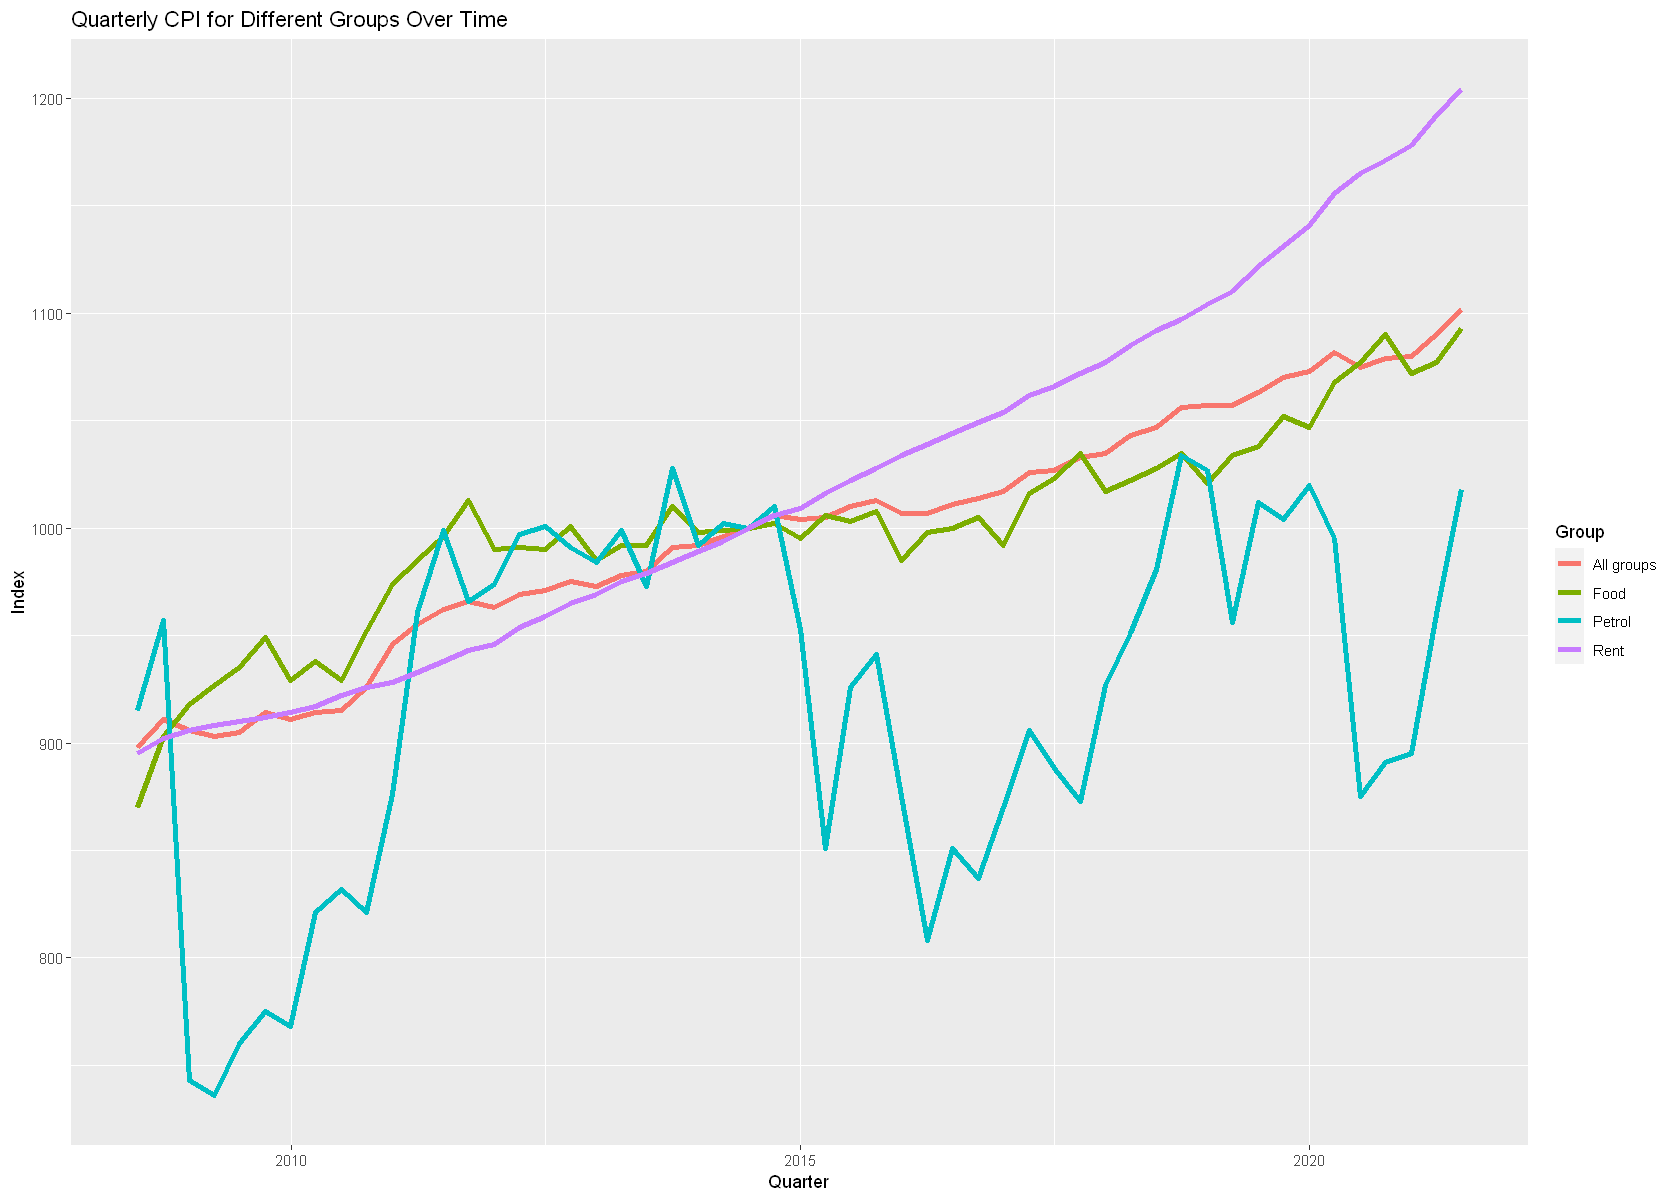

In [11]:
cpi_plot <- CPI_PRF %>%
    gather(key = group, value = index, -quarter) %>%
    arrange(quarter) %>%
    mutate(quarter = as.Date(as.yearqtr(quarter, format = "%YQ%q"), frac = 1)) %>%
    ggplot(mapping = aes(x = quarter, y = index, group = group, colour = group)) +
    scale_colour_discrete("Group") + ggtitle("Quarterly CPI for Different Groups Over Time") +
    ylab("Index") + xlab("Quarter") + geom_line(lwd=1.5)
    geom_line()
cpi_plot

### Import/Export factors

In [12]:
os_c_df <- read_csv("data/Overseas_Cargo_dataset.csv")
os_c_df %>% glimpse()

New names:
* `` -> ...1

Rows: 39592 Columns: 25

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (20): ResourceID, Subject, Title, Description, Notes, Caveats, Source, ...
dbl   (3): ...1, Value, Multiplier
dttm  (1): Modified
date  (1): Period


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Rows: 39,592
Columns: 25
$ ...1        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,~
$ ResourceID  <chr> "OSC1.1", "OSC1.1", "OSC1.1", "OSC1.1", "OSC1.1", "OSC1.1"~
$ Subject     <chr> "Overseas Cargo Statistics", "Overseas Cargo Statistics", ~
$ Title       <chr> "Overseas cargo exports and imports by New Zealand port", ~
$ Description <chr> "Overseas cargo records all goods, value and gross weight,~
$ Notes       <chr> "These figures will differ from those of merchandise trade~
$ Caveats     <chr> "Overseas trade and cargo data is provided by exporters/im~
$ Source      <chr> "Stats NZ", "Stats NZ", "Stats NZ", "Stats NZ", "Stats NZ"~
$ SourceURL   <chr> "www.stats.govt.nz", "www.stats.govt.nz", "www.stats.govt.~
$ Modified    <dttm> 2021-09-23 22:45:00, 2021-09-23 22:45:00, 2021-09-23 22:4~
$ Frequency   <chr> "Monthly", "Monthly", "Monthly", "Monthly", "Monthly", "Mo~
$ Var1        <chr> "Trade Class", "Trade Class", "Trade Class", "Trade Class"~
$ Var2        <

In [13]:
trade_df <- os_c_df %>%
    filter(
        Label2 == "Total All Cargo", 
        Status == "F"
    ) %>% 
    select(Period, Label1, Measure, Value) %>%
    mutate(Measure = ifelse(Measure != "Gross weight value", "NZD_Value_mil", "Gross_Weight_kt"), 
           Value = Value / 1000) %>%
    spread(key=Measure, value=Value) %>%
    rename(Trade = Label1) %>%
    arrange(Period, Trade)
trade_df %>% head()

Period,Trade,Gross_Weight_kt,NZD_Value_mil
<date>,<chr>,<dbl>,<dbl>
1988-01-31,Exports,550.458,799.476
1988-01-31,Imports,794.129,892.909
1988-02-29,Exports,906.514,1140.441
1988-02-29,Imports,726.047,940.189
1988-03-31,Exports,971.862,1236.020
1988-03-31,Imports,516.128,883.951


In [14]:
ImpExp_Value_df <- trade_df %>% 
    select(Period, Trade, NZD_Value_mil) %>%
    spread(key=Trade, value=NZD_Value_mil) %>%
    arrange(Period)

ImpExp_Weight_df <- trade_df %>% 
    select(Period, Trade, Gross_Weight_kt) %>%
    spread(key=Trade, value=Gross_Weight_kt) %>%
    arrange(Period)

merge_ImpExp_df <- function(ImpExp_Weight, ImpExp_Value) {
    ImpExp_df <- merge(x = ImpExp_Weight, y = ImpExp_Value, by = "Period")
#     names(ImpExp_df)[names(ImpExp_df) == renameCol] <- status
    ImpExp_df %<>% rename(Export_weight=Exports.x, Export_value=Exports.y,
                        Import_weight=Imports.x, Import_value=Imports.y)
    return (ImpExp_df)
}
merge_ImpExp_df(ImpExp_Weight_df, ImpExp_Value_df) %>% tail()

,Period,Export_weight,Import_weight,Export_value,Import_value
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
396,2020-12-31,3774.384,1933.317,5621.920,5453.775
397,2021-01-31,2787.226,2169.879,4342.260,5286.249
398,2021-02-28,3544.513,1619.116,4616.824,4374.333
399,2021-03-31,4080.263,2127.964,5926.991,6008.548
400,2021-04-30,4112.935,1866.328,5585.766,5164.883
401,2021-05-31,3656.230,2086.383,6281.892,5965.387


In [15]:
startDate = as.Date("2019-10-01")
ImpExp_Value_plot <- ImpExp_Value_df %>% filter(Period > startDate) %>%
    gather(key=trade, value=value, -Period) %>%
    group_by(trade) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA)) %>%
    ggplot(mapping = aes(x = Period, y = RA_Value, colour = trade)) + geom_line(lwd=2) +
    ggtitle("Total Monthly Value of Import and Export, rolling 8-month average") +
    ylab("Value (millions NZD)") + xlab("Date") + theme(legend.title = element_blank()) +
    geom_line() +
    scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

ImpExp_Weight_plot <- ImpExp_Weight_df %>% filter(Period > startDate) %>%
    gather(key=ImEx, value=value, -Period) %>%
    group_by(ImEx) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA)) %>%
    ggplot(mapping = aes(x = Period, y = RA_Value, colour = ImEx)) + geom_line(lwd=2) +
    ggtitle("Total Monthly Weight of Import and Export, rolling 8-month average") +
    ylab("Weight (thousands of tonnes)") + xlab("Date") + 
    theme(legend.title = element_blank()) +
    geom_line() +
    scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."


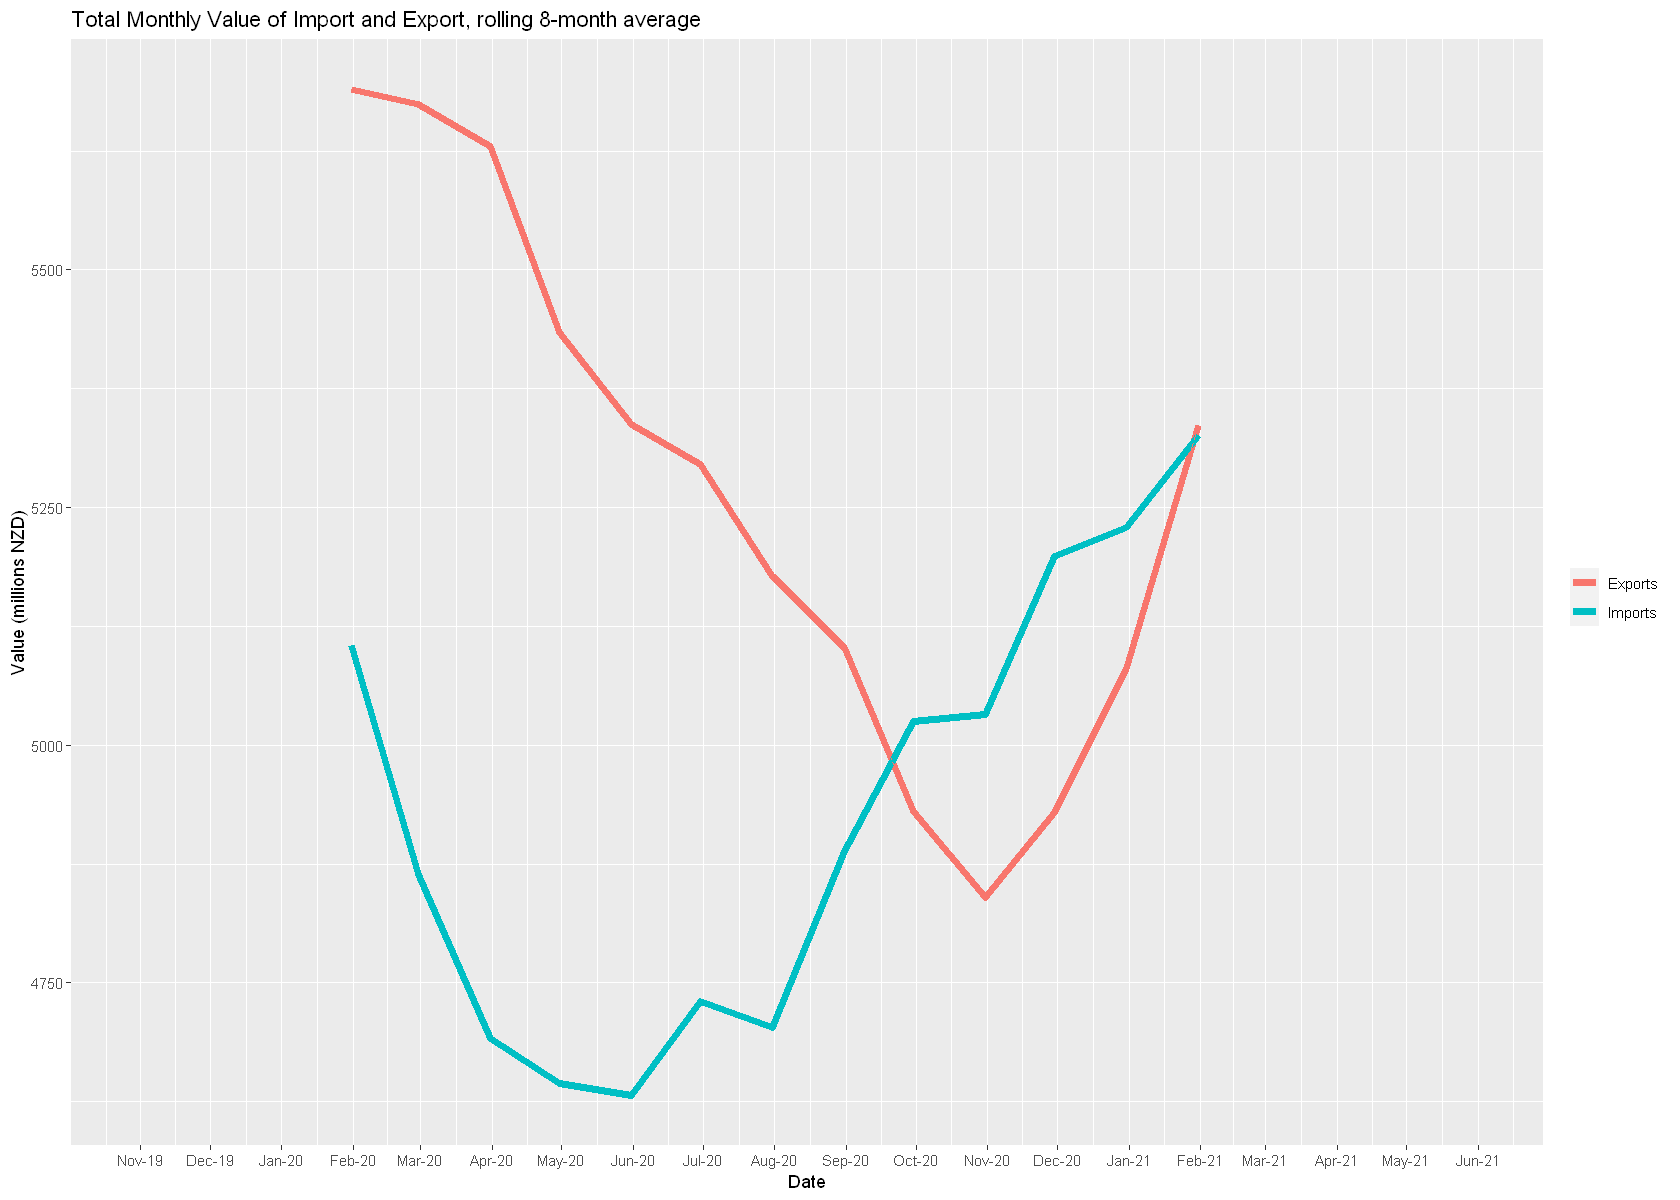

Saving 6.67 x 6.67 in image

Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Saving 6.67 x 6.67 in image

Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."


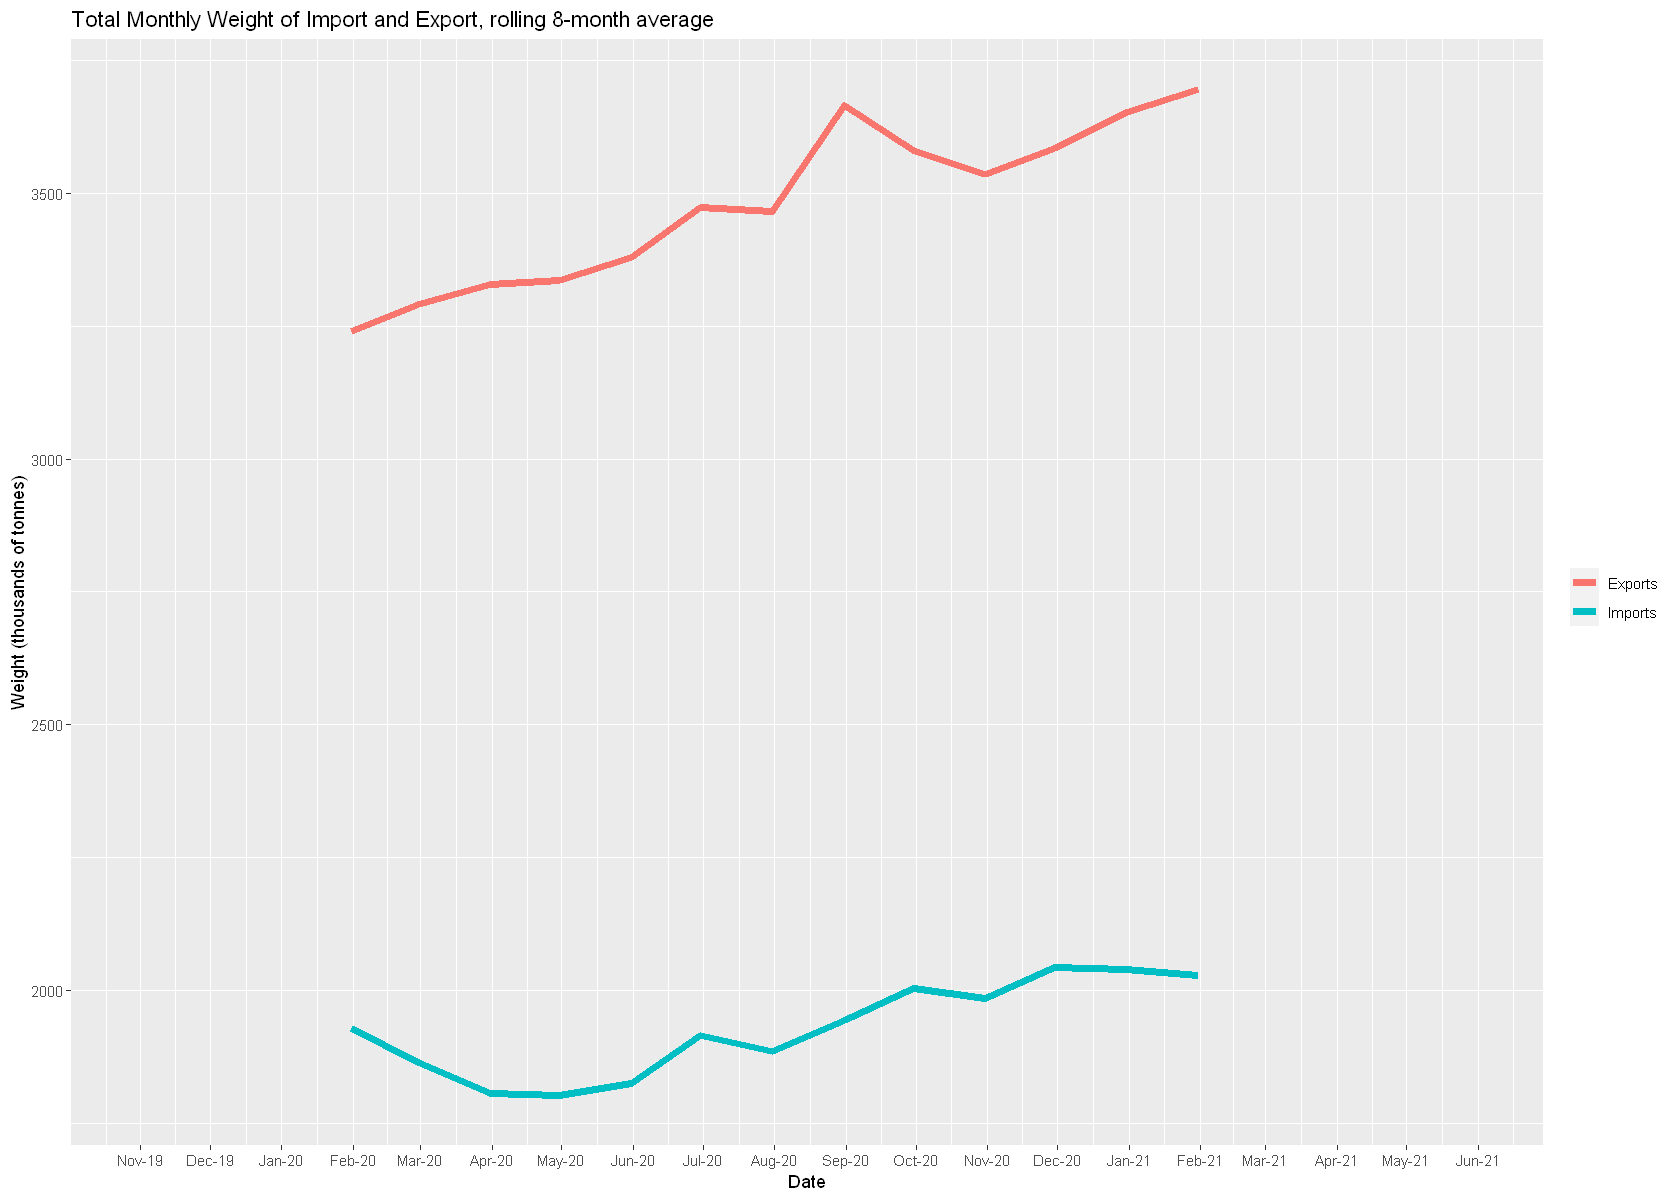

In [16]:
ImpExp_Value_plot
ImpExp_Weight_plot

# savePlot("ImpExp_Weight.png", ImpExp_Weight_plot)
# savePlot("ImpExp_Value.png", ImpExp_Value_plot)

## Combine all factors

In [17]:
startDate = as.Date("2016-01-01")
cpi_2020_df <- CPI_PRF %>%
    gather(key = group, value = index, -quarter) %>%
    rename(Group=group, HPI=index, Quarter=quarter) %>% arrange(Quarter) %>% 
    mutate(Quarter = as.Date(as.yearqtr(Quarter, format = "%YQ%q"), frac = 1)) %>%
    filter(Quarter >= startDate)

ImpExp_Weight_2020_df <- ImpExp_Weight_df %>% filter(Period > startDate) %>%
    gather(key=ImEx, value=value, -Period) %>%
    group_by(ImEx) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA))

ImpExp_Value_2020_df <- ImpExp_Value_df %>% filter(Period > startDate) %>%
    gather(key=ImEx, value=value, -Period) %>%
    group_by(ImEx) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA))

# Brrrrrr
# graph_df %>% tail()
# graph_week_df %>% tail()
# cpi_2020_df %>% tail()
# merge_ImpExp_df(ImpExp_Weight_df, ImpExp_Value_df) %>% tail()
ImpExp_Weight_2020_df %<>% mutate(ImEx=paste(ImEx, "weight (tons)", sep="-"))
ImpExp_Value_2020_df %<>% mutate(ImEx=paste(ImEx, "value (mil. NZD)", sep="-"))
ImpExp_Weight_2020_df %>% tail()
ImpExp_Value_2020_df %>% tail()


Period,ImEx,value,RA_Value
<date>,<chr>,<dbl>,<dbl>
2020-12-31,Imports-weight (tons),1933.317,2038.915
2021-01-31,Imports-weight (tons),2169.879,2027.015
2021-02-28,Imports-weight (tons),1619.116,NA
2021-03-31,Imports-weight (tons),2127.964,NA
2021-04-30,Imports-weight (tons),1866.328,NA
2021-05-31,Imports-weight (tons),2086.383,NA


Period,ImEx,value,RA_Value
<date>,<chr>,<dbl>,<dbl>
2020-12-31,Imports-value (mil. NZD),5453.775,5229.266
2021-01-31,Imports-value (mil. NZD),5286.249,5325.907
2021-02-28,Imports-value (mil. NZD),4374.333,NA
2021-03-31,Imports-value (mil. NZD),6008.548,NA
2021-04-30,Imports-value (mil. NZD),5164.883,NA
2021-05-31,Imports-value (mil. NZD),5965.387,NA


In [22]:
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1), rgb(0,0,0,1))
covid_weekly_plot <- ggplot() +
#         Import/Export Lines
        geom_line(lwd=1.5, data=ImpExp_Weight_2020_df,
                 aes(x = Period, y = RA_Value, colour = ImEx)) +
        geom_line(lwd=1.5, data=ImpExp_Value_2020_df,
                 aes(x = Period, y = RA_Value, colour = ImEx)) +

#         Covid-case count barplot
        geom_bar(stat='identity', data = graph_week_df, alpha=0.3, width=12,
                 aes(x=Monday, y=Value, fill=factor(Status)) ) +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +
        geom_line(data=getByStatus(graph_df, "Deceased"), colour=color[3], size=1,
                 aes(x=Date, y=Value)) +

#         CPI_lines
#         geom_line(lwd=1.5, data=cpi_2020_df,
#                  aes(x=Quarter, y=HPI*4, group=Group, colour=Group)) +

#         Secondary Y-scale
#         scale_y_continuous("Total case", 
#             sec.axis = sec_axis(~ . *0.25, name = "Index")
#         ) +

        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), # x-axis flip
             legend.position = c(0.1, 0.15)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y") 

covid_weekly_plot <- covid_weekly_plot +
ggtitle("Title Graph") +
ylab("Total cases") + xlab("Months") +
labs(fill="Status")

cpi_2020_plot <- cpi_2020_df %>%
    ggplot(mapping = aes(x = Quarter, y = HPI, group = Group, colour = Group)) +
    scale_colour_discrete("Group") + ggtitle("Quarterly CPI for Different Groups Over Time") +
    ylab("Index") + xlab("Quarter") + geom_line(lwd=1.5)


Warning message:
"Removed 6 rows containing missing values (position_stack)."
Warning message:
"position_stack requires non-overlapping x intervals"
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."


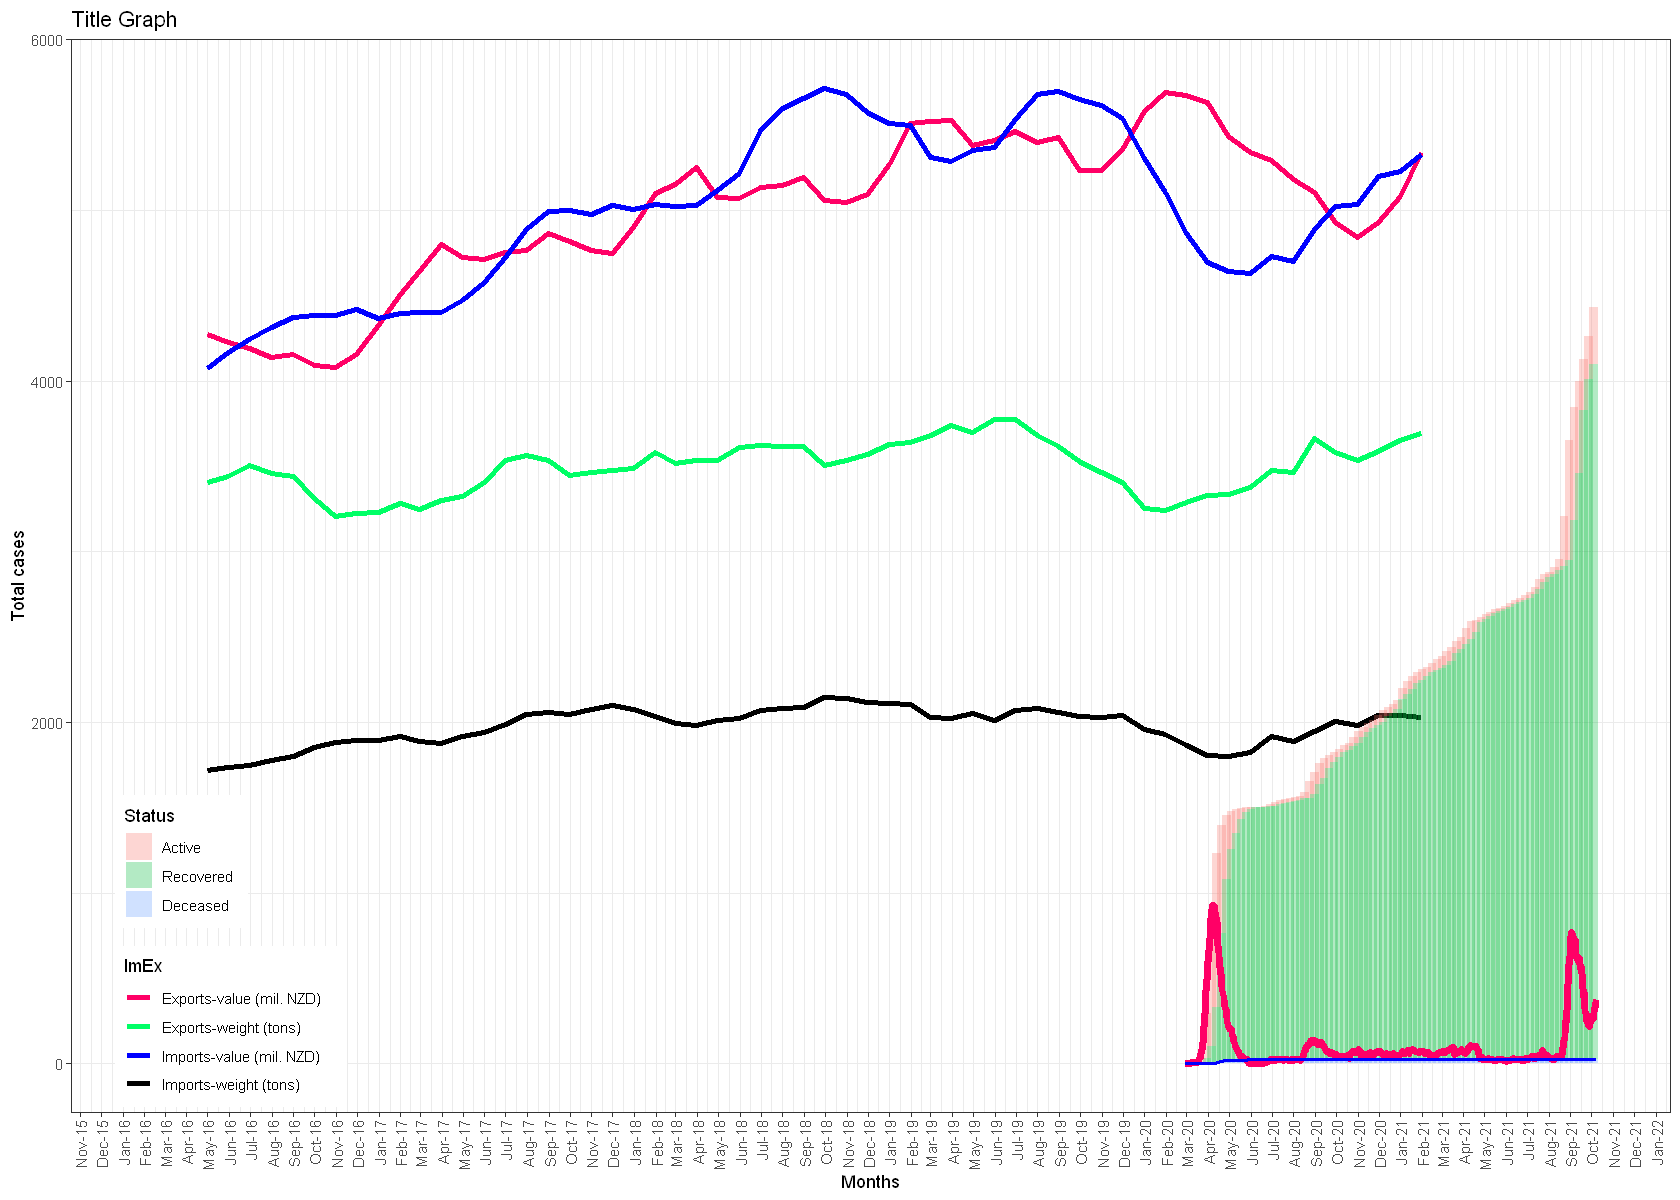

Saving 6.67 x 6.67 in image

Warning message:
"Removed 6 rows containing missing values (position_stack)."
Warning message:
"position_stack requires non-overlapping x intervals"
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Saving 6.67 x 6.67 in image



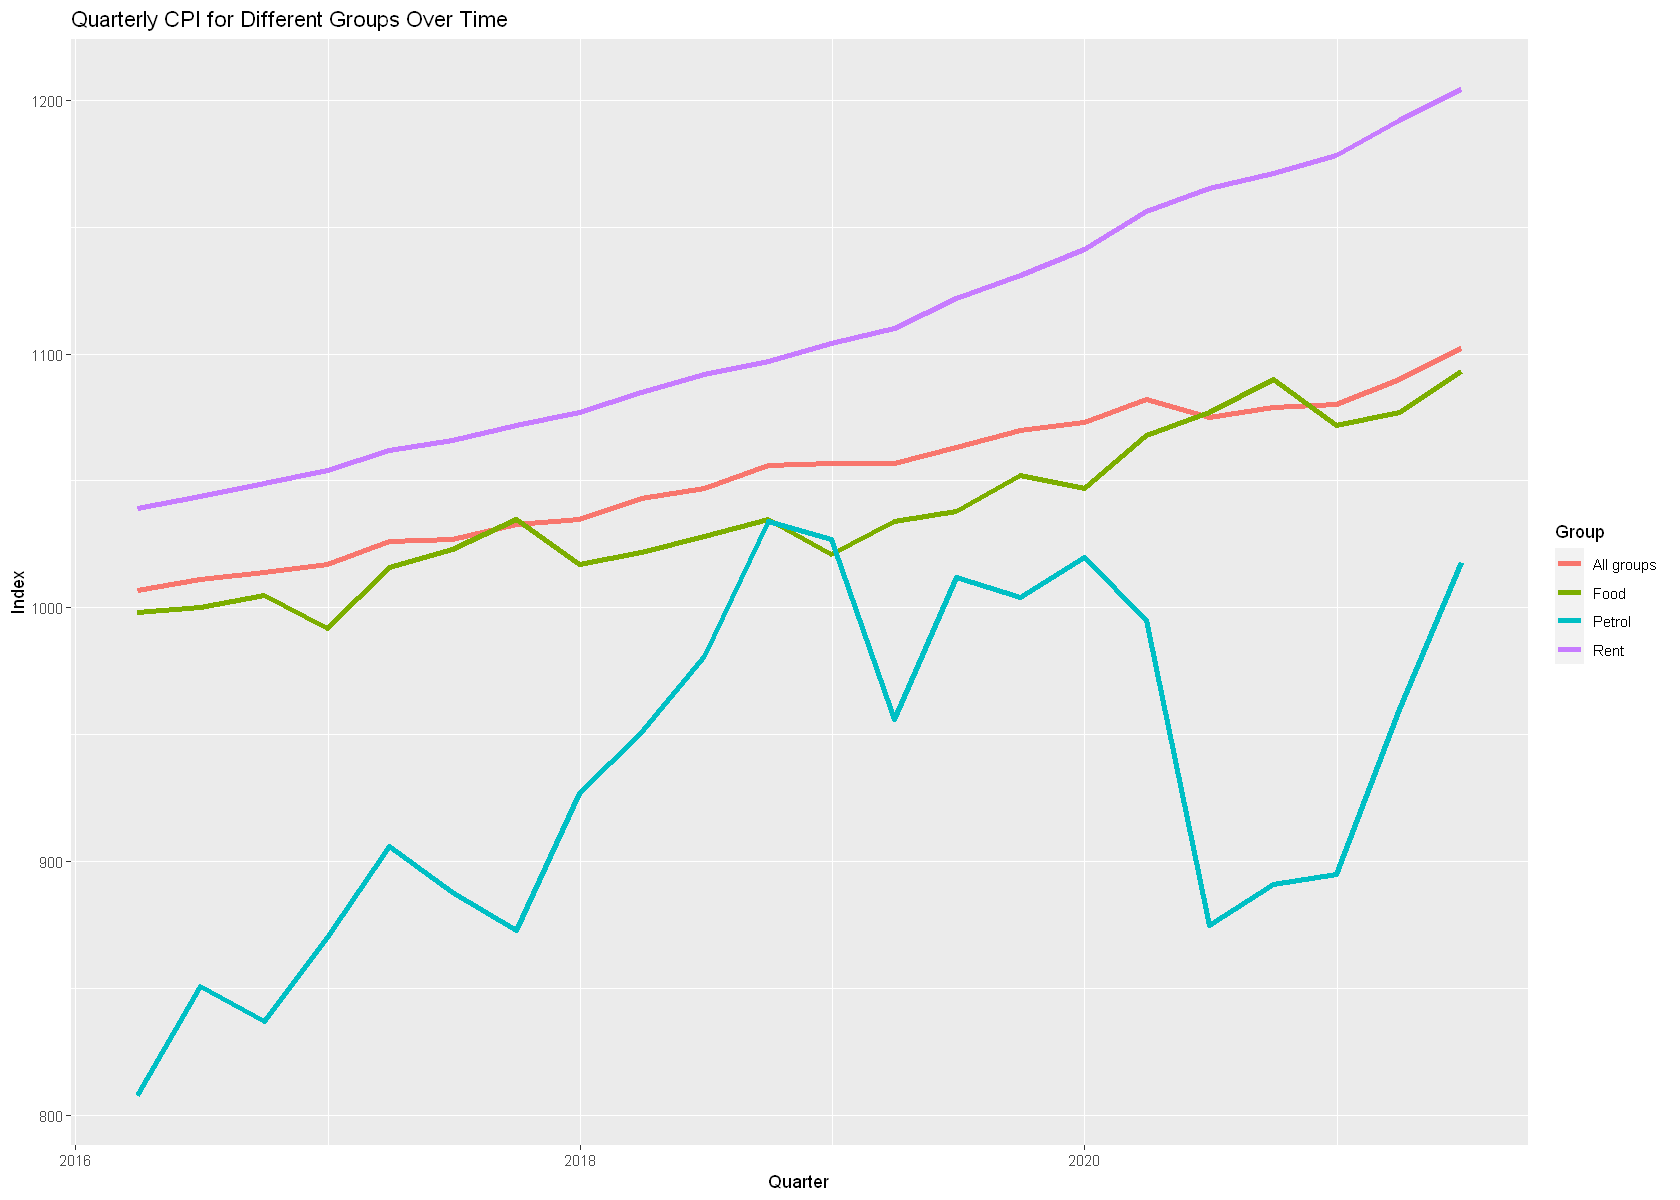

In [23]:
covid_weekly_plot
cpi_2020_plot

savePlot("CombinedPlot_ImEx.png", covid_weekly_plot)
savePlot("CPI2020.png", cpi_2020_plot)